# Moving Average - TLDR

In [32]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

- Simulate an MA(3) process and make forecasts

$$y_t = 0.9\theta_{t–1} + 0.3\theta_{t–2} + 0.2\theta_{t–3}$$

In [33]:
# MA(3)
ma3 = np.array([1, 0.9, 0.3, 0.2]) # yt = 0.9 * theta(t-1) + 0.3 * theta(t-2) + 0.2* theta(t-3)
ar3 = np.array([1,  0,    0,  0])
 
MA3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

In [42]:
fig = px.line(MA3_process)
fig.update_layout(
    yaxis_title='Value',
    xaxis_title='Time',
    title='Simulated MA(3) process with 10000 samples'
)  

## EDA
- Run the ADF test, and check if the process is stationary.
- Plot the ACF, and see if there are significant coefficients after lag 2.

In [35]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [36]:
check_stationarity(MA3_process)

ADF Statistic : -22.87193, p-value: 0.00000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Statistic: 0.31638, p-value: 0.10000
Stationary


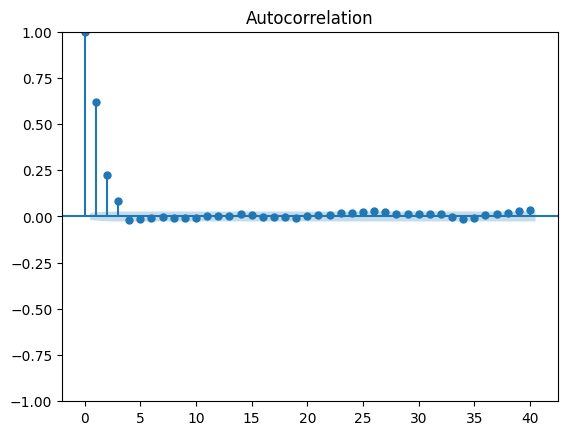

In [37]:
plot_acf(MA3_process);

- The series is stationary & it has 3 significant coefficients after `lag=0`

## Train Test Split

In [38]:
df = pd.DataFrame({'value': MA3_process})

train = df[:-200]
test = df[-200:]

In [39]:
train.shape, test.shape

((9800, 1), (200, 1))

## Forecasting
- Forecast 3 timesteps at a time using the `recursive_forecast` function

In [62]:
def rolling_forecast(df: pd.DataFrame,
                     train_len: int, # training length
                     horizon: int,   # horizon of the forecast
                     window: int,    # how many steps to forecast
                     method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean[:horizon] # [:horizon] to ensure the rolling forecast returns sample number of values with the test set
    
    if method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value[:horizon] 
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,window))                  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            # "predicted_mean" method allows us to retrieve the actual value of the forecast 
            # as defined by the statsmodels library.
            oos_pred = predictions.predicted_mean.iloc[-window:]    
            pred_MA.extend(oos_pred)
            
        return pred_MA[:horizon] 

In [65]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA3 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_MA3'] = pred_MA3

test.head()

,value,pred_mean,pred_last_value,pred_MA3
9800,-0.090451,-0.004809,-1.184449,-0.997254
9801,0.965698,-0.004809,-1.184449,-0.344161
9802,2.802072,-0.004809,-1.184449,-0.226325
9803,1.397224,-0.004433,2.802072,2.378104
9804,0.700887,-0.004433,2.802072,0.733305


In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-250:].index, y=df[-250:]['value'], name='actual', line = dict(color='royalblue')))

for pred_type in ["pred_mean", "pred_last_value",	"pred_MA3"]: 
    fig.add_trace(go.Scatter(x=test.index, y=test[pred_type], name=pred_type, line = dict(dash='dash')))
fig.update_layout(
    yaxis_title='Value',
    xaxis_title='Time',
    title='Prediction on Test Set'
)  
fig.show()

In [70]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA3'])

print(mse_mean, mse_last, mse_MA)

1.9248140859815992 3.1865529484710264 1.5065280391116482


- The MA(3) model achieves the lowest MSE, therefore, it is the champion model.